In [1]:
!mkdir ~/.kaggle

In [2]:
!cp /content/drive/MyDrive/ensemble-learning/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/ensemble-learning/kaggle.json': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Upload the kaggle.json file
from google.colab import files
files.upload()

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set the permissions of the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## **1. Downloading dataset**




In [5]:
import kaggle

import os

dataset_name = 'gunavenkatdoddi/eye-diseases-classification'

download_dir = '/content/drive/MyDrive/ensemble-learning/eye-diseases-dataset'

kaggle.api.dataset_download_files(dataset_name, path=download_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


## **2. Auggmenting and spliting dataset**

In [6]:
!pip install Augmentor

In [7]:
!pip install split-folders

In [8]:
import splitfolders

dataset_dir = '/content/drive/MyDrive/ensemble-learning/eye-diseases-dataset/dataset'
output_dir = "/content/drive/MyDrive/ensemble-learning/dataset"

splitfolders.ratio(
    input=dataset_dir,
    output=output_dir,
    seed=42,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None
)

Copying files: 4217 files [01:20, 52.63 files/s]


## **3. Starting training**

In [9]:
IMAGE_SIZE = [224, 224, 3]
EPOCHS=15
BATCH_SIZE=32

In [10]:
VGG16_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/vgg16-{EPOCHS}-epochs.h5"
RESNET50_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/resnet50-{EPOCHS}-epochs.h5"
ENSEMBLE_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/ensemble-{EPOCHS}-epochs.h5"
INCEPTION_V3_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/inceptionv3-{EPOCHS}-epochs.h5"
WEIGHTED_ENSEMBLE_MODEL_PATH=f"/content/drive/MyDrive/ensemble-learning/models/weighted-ensemble-{EPOCHS}-epochs.h5"

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
train_dir = '/content/drive/MyDrive/ensemble-learning/dataset/train'
test_dir = '/content/drive/MyDrive/ensemble-learning/dataset/test'
val_dir = '/content/drive/MyDrive/ensemble-learning/dataset/val'

In [13]:
train_data_gen = ImageDataGenerator(rescale=1. / 225)
test_data_gen = ImageDataGenerator(rescale=1. / 225 )
val_data_gen = ImageDataGenerator(rescale=1. / 225 )

In [14]:
train_data = train_data_gen.flow_from_directory(train_dir, target_size=(224,224), class_mode='categorical', batch_size=BATCH_SIZE)
test_data = test_data_gen.flow_from_directory(test_dir, target_size=(224,224), class_mode='categorical', batch_size=BATCH_SIZE)
val_data = val_data_gen.flow_from_directory(val_dir, target_size=(224,224), class_mode='categorical', batch_size=BATCH_SIZE)

Found 3372 images belonging to 4 classes.
Found 426 images belonging to 4 classes.
Found 419 images belonging to 4 classes.


## **3.1 trainging with pretrained model**

In [15]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Sequential

In [16]:
import matplotlib.pyplot as plt

def plot_training(history, title):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], marker = 'o')
    plt.plot(history.history['val_loss'], marker = 'o')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], marker = 'o')
    plt.plot(history.history['val_accuracy'], marker = 'o')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.suptitle(title)

    filename = title.lower().replace(" ","-")
    filename = f"{filename}-{EPOCHS}-epochs.png"
    plt.savefig(f"/content/drive/MyDrive/ensemble-learning/results/{filename}")
    plt.show()


In [17]:
def train_model(base_model):
    pass

**training vgg16**

In [18]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)

58889256/58889256 [==============================] - 4s 0us/step


In [19]:
for layer in vgg16.layers:
    layer.trainable = False

In [20]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
vgg16 = Sequential([
    vgg16,
    # GlobalAveragePooling2D(),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(200, activation='relu'),
    Dense(4, activation='softmax')
])


In [22]:
vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 400)               10035600  
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 24831292 (94.72 MB)
Trainable params: 10116604 (38.59 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [23]:
vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:
vgg16_history = vgg16.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/15
106/106 [==============================] - 56s 430ms/step - loss: 0.8356 - accuracy: 0.7298 - val_loss: 0.5213 - val_accuracy: 0.7876
Epoch 2/15
106/106 [==============================] - 43s 402ms/step - loss: 0.3918 - accuracy: 0.8425 - val_loss: 0.4607 - val_accuracy: 0.8401
Epoch 3/15
106/106 [==============================] - 41s 389ms/step - loss: 0.3473 - accuracy: 0.8574 - val_loss: 0.3234 - val_accuracy: 0.8735
Epoch 4/15
106/106 [==============================] - 47s 446ms/step - loss: 0.3001 - accuracy: 0.8832 - val_loss: 0.3481 - val_accuracy: 0.8616
Epoch 5/15
106/106 [==============================] - 42s 394ms/step - loss: 0.2741 - accuracy: 0.8921 - val_loss: 0.3066 - val_accuracy: 0.8902
Epoch 6/15
106/106 [==============================] - 43s 406ms/step - loss: 0.2653 - accuracy: 0.8941 - val_loss: 0.3740 - val_accuracy: 0.8663
Epoch 7/15
106/106 [==============================] - 41s 386ms/step - loss: 0.2376 - accuracy: 0.9042 - val_loss: 0.2936 - val_ac

In [25]:
test_loss, test_accuracy = vgg16.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


14/14 [==============================] - 7s 522ms/step - loss: 0.3290 - accuracy: 0.8756
Test Loss: 0.32895371317863464
Test Accuracy: 0.8755868673324585


In [26]:
import os

# Directory path
directory = "/content/drive/MyDrive/ensemble-learning/results"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Now you can proceed with saving the plot
plt.savefig(f"/content/drive/MyDrive/ensemble-learning/results/vgg16-training-results-5-epochs.png")

<Figure size 640x480 with 0 Axes>

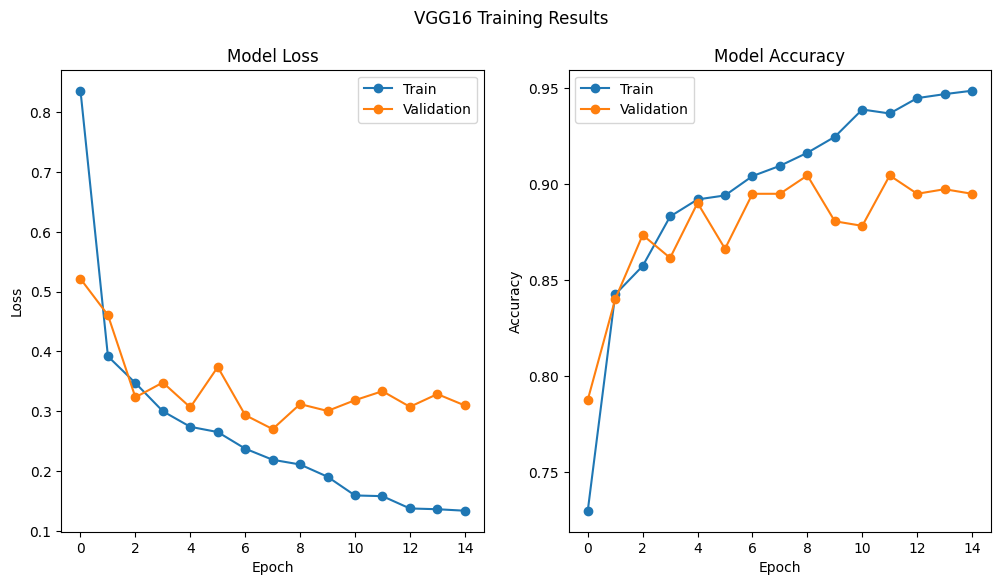

In [27]:
plot_training(vgg16_history, "VGG16 Training Results")

In [28]:
vgg16.save(VGG16_MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**training resnet**

In [29]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)

94765736/94765736 [==============================] - 5s 0us/step


In [30]:
for layer in resnet.layers:
    layer.trainable = False

In [31]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [32]:
resnet50 = Sequential([
    resnet50,
    Flatten(),
    Dense(200, activation='relu'),
    Dense(4, activation='softmax')
])


In [33]:
resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 200)               20070600  
                                                                 
 dense_4 (Dense)             (None, 4)                 804       
                                                                 
Total params: 43659116 (166.55 MB)
Trainable params: 43605996 (166.34 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [34]:
resnet50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
resnet50_history = resnet50.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/15
106/106 [==============================] - 96s 504ms/step - loss: 3.3375 - accuracy: 0.5993 - val_loss: 1.6284 - val_accuracy: 0.2387
Epoch 2/15
106/106 [==============================] - 51s 481ms/step - loss: 0.6058 - accuracy: 0.7633 - val_loss: 4.7161 - val_accuracy: 0.2458
Epoch 3/15
106/106 [==============================] - 49s 458ms/step - loss: 0.4858 - accuracy: 0.8025 - val_loss: 7.8802 - val_accuracy: 0.2458
Epoch 4/15
106/106 [==============================] - 50s 473ms/step - loss: 1.0157 - accuracy: 0.7414 - val_loss: 6.7004 - val_accuracy: 0.2458
Epoch 5/15
106/106 [==============================] - 48s 450ms/step - loss: 0.4992 - accuracy: 0.8046 - val_loss: 5.8290 - val_accuracy: 0.2458
Epoch 6/15
106/106 [==============================] - 50s 469ms/step - loss: 0.4297 - accuracy: 0.8330 - val_loss: 6.7673 - val_accuracy: 0.2458
Epoch 7/15
106/106 [==============================] - 47s 439ms/step - loss: 0.3827 - accuracy: 0.8449 - val_loss: 6.4734 - val_ac

In [36]:
test_loss, test_accuracy = resnet50.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

14/14 [==============================] - 6s 428ms/step - loss: 0.4357 - accuracy: 0.8005
Test Loss: 0.43571317195892334
Test Accuracy: 0.8004694581031799


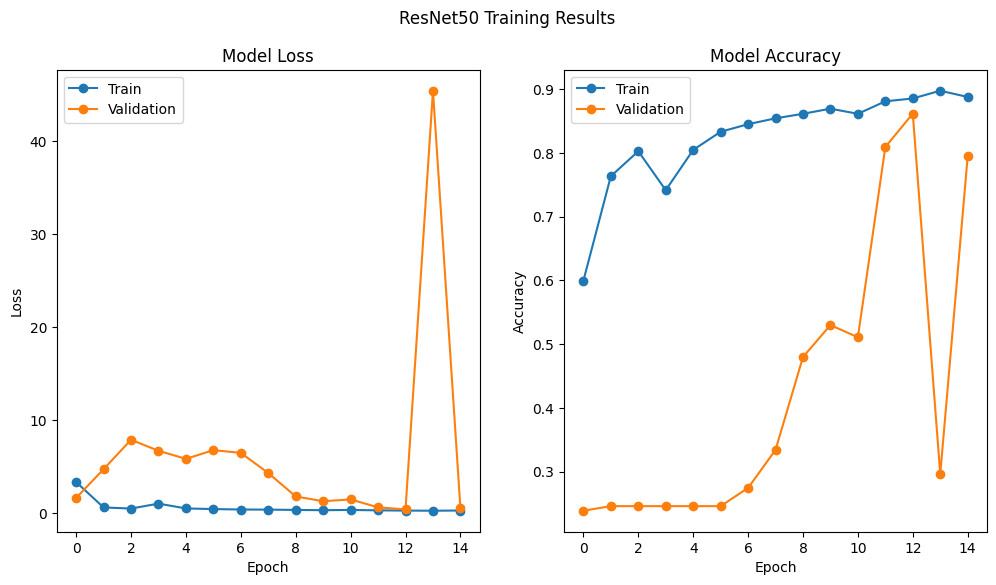

In [37]:
plot_training(resnet50_history, "ResNet50 Training Results")

In [38]:
resnet50.save(RESNET50_MODEL_PATH)

**training InceptionV3**

In [39]:
inceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)

87910968/87910968 [==============================] - 5s 0us/step


In [40]:
for layer in inceptionV3.layers:
    layer.trainable = False

In [41]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [42]:
inceptionV3 = Sequential([
    inceptionV3,
    Flatten(),
    Dense(200, activation='relu'),
    Dense(4, activation='softmax')
])

In [43]:
inceptionV3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 200)               10240200  
                                                                 
 dense_6 (Dense)             (None, 4)                 804       
                                                                 
Total params: 32043788 (122.24 MB)
Trainable params: 10241004 (39.07 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [44]:
inceptionV3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
inceptionV3_history = inceptionV3.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=64
)


Epoch 1/15
106/106 [==============================] - 54s 417ms/step - loss: 3.9769 - accuracy: 0.6889 - val_loss: 0.7086 - val_accuracy: 0.8305
Epoch 2/15
106/106 [==============================] - 40s 377ms/step - loss: 0.4497 - accuracy: 0.8636 - val_loss: 0.4304 - val_accuracy: 0.8711
Epoch 3/15
106/106 [==============================] - 40s 381ms/step - loss: 0.1790 - accuracy: 0.9327 - val_loss: 0.5133 - val_accuracy: 0.8544
Epoch 4/15
106/106 [==============================] - 38s 357ms/step - loss: 0.1788 - accuracy: 0.9440 - val_loss: 0.4726 - val_accuracy: 0.8568
Epoch 5/15
106/106 [==============================] - 41s 383ms/step - loss: 0.1215 - accuracy: 0.9659 - val_loss: 0.7832 - val_accuracy: 0.8473
Epoch 6/15
106/106 [==============================] - 39s 365ms/step - loss: 0.1235 - accuracy: 0.9582 - val_loss: 0.5369 - val_accuracy: 0.8807
Epoch 7/15
106/106 [==============================] - 39s 362ms/step - loss: 0.0628 - accuracy: 0.9778 - val_loss: 0.4943 - val_ac

In [46]:
test_loss, test_accuracy = inceptionV3.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

14/14 [==============================] - 6s 432ms/step - loss: 0.6632 - accuracy: 0.8239
Test Loss: 0.6631976962089539
Test Accuracy: 0.8239436745643616


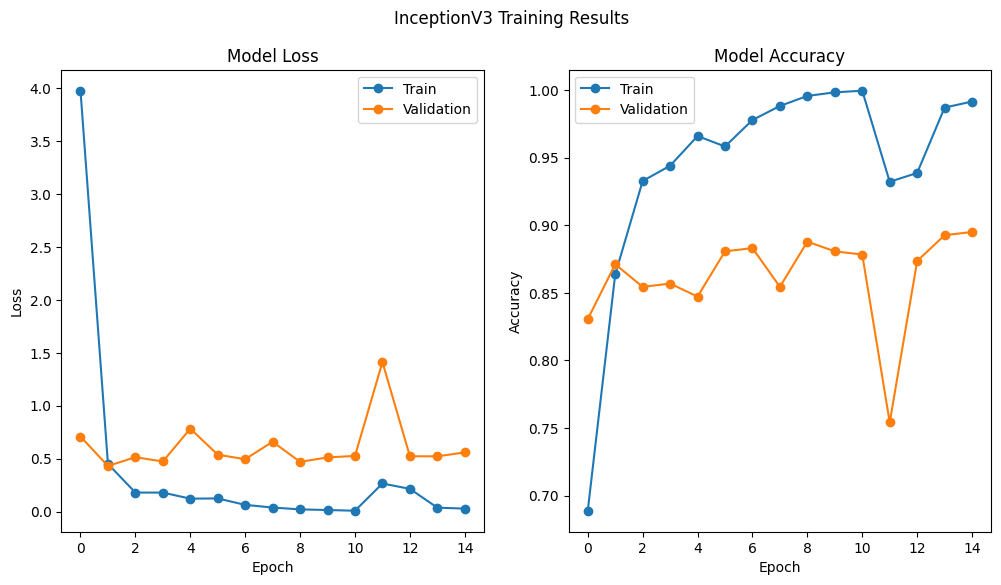

In [47]:
plot_training(inceptionV3_history, "InceptionV3 Training Results")

In [48]:
inceptionV3.save(INCEPTION_V3_MODEL_PATH)

## **3.2 implementing ensemble model**

In [49]:
from keras.models import Model, load_model
from keras.layers import Average, Input

In [50]:
vgg16 = load_model(VGG16_MODEL_PATH)
vgg16_model = Model(inputs=vgg16.inputs,
                       outputs=vgg16.outputs,
                       name='VGG16_model')

resnet = load_model(RESNET50_MODEL_PATH)
resnet_model = Model(inputs=resnet.inputs,
                            outputs=resnet.outputs,
                            name='ResNet50_model')

inceptionV3 = load_model(INCEPTION_V3_MODEL_PATH)
inceptionV3_model = Model(inputs=inceptionV3.inputs,
                            outputs=inceptionV3.outputs,
                            name='inceptionV3_model')

# trained_models = [vgg16_model, resnet_model, inceptionV3_model]
trained_models = [vgg16_model,  inceptionV3_model]

model_input = Input(shape=IMAGE_SIZE)

model_outputs = [model(model_input) for model in trained_models]
ensemble_output = Average()(model_outputs)

ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [51]:
ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
ensemble_history = ensemble_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/15
106/106 [==============================] - 52s 406ms/step - loss: 0.1133 - accuracy: 0.9769 - val_loss: 0.3684 - val_accuracy: 0.8926
Epoch 2/15
106/106 [==============================] - 46s 430ms/step - loss: 0.1312 - accuracy: 0.9626 - val_loss: 0.4188 - val_accuracy: 0.9069
Epoch 3/15
106/106 [==============================] - 42s 390ms/step - loss: 0.1466 - accuracy: 0.9517 - val_loss: 0.3579 - val_accuracy: 0.8592
Epoch 4/15
106/106 [==============================] - 44s 416ms/step - loss: 0.1061 - accuracy: 0.9683 - val_loss: 0.3897 - val_accuracy: 0.9045
Epoch 5/15
106/106 [==============================] - 42s 398ms/step - loss: 0.1158 - accuracy: 0.9712 - val_loss: 0.4139 - val_accuracy: 0.9189
Epoch 6/15
106/106 [==============================] - 45s 420ms/step - loss: 0.0713 - accuracy: 0.9846 - val_loss: 0.4799 - val_accuracy: 0.9045
Epoch 7/15
106/106 [==============================] - 41s 390ms/step - loss: 0.3631 - accuracy: 0.8731 - val_loss: 0.9093 - val_ac

In [53]:
test_loss, test_accuracy = ensemble_model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

14/14 [==============================] - 4s 301ms/step - loss: 0.4291 - accuracy: 0.7981
Test Loss: 0.42913997173309326
Test Accuracy: 0.7981220483779907


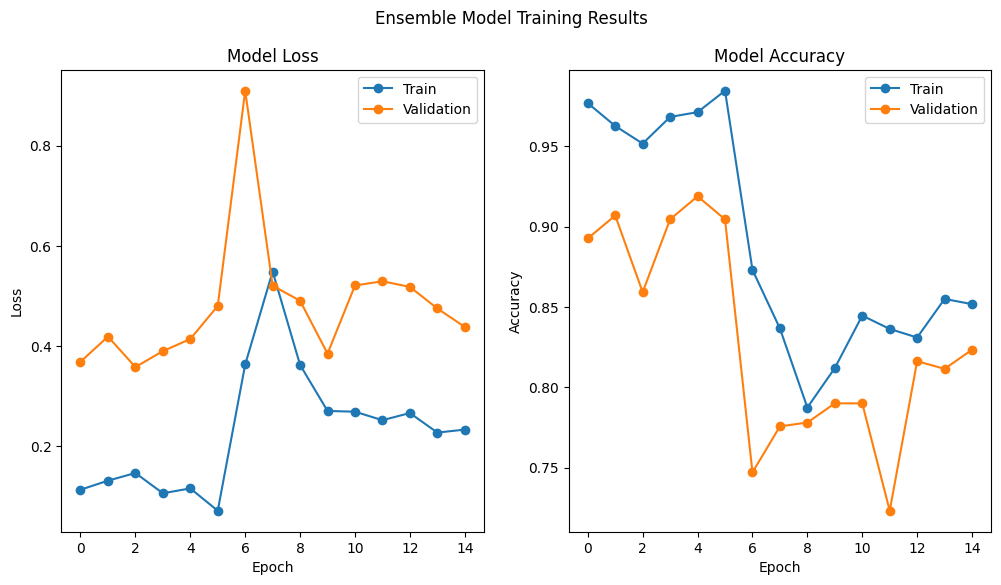

In [54]:
plot_training(ensemble_history, "Ensemble Model Training Results")

In [55]:
ensemble_model.save(ENSEMBLE_MODEL_PATH)

## **3.3 implementing weighted ensembling**

In [56]:
from keras.layers import Layer

In [57]:
class WeightedAverageLayer(Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3= w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]+ self.w3 * inputs[2]

In [58]:
vgg16 = load_model(VGG16_MODEL_PATH)
vgg16_model = Model(inputs=vgg16.inputs,
                       outputs=vgg16.outputs,
                       name='VGG16_model')

resnet = load_model(RESNET50_MODEL_PATH)
resnet_model = Model(inputs=resnet.inputs,
                            outputs=resnet.outputs,
                            name='ResNet50_model')

inceptionV3 = load_model(INCEPTION_V3_MODEL_PATH)
inceptionV3_model = Model(inputs=inceptionV3.inputs,
                            outputs=inceptionV3.outputs,
                            name='inceptionV3_model')


trained_models = [inceptionV3_model, vgg16_model, resnet_model]
# trained_models = [vgg16_model,  inceptionV3_model]

model_input = Input(shape=IMAGE_SIZE)

model_outputs = [model(model_input) for model in trained_models]
ensemble_output = WeightedAverageLayer(0.6, 0.3, 0.1)(model_outputs)

weighted_ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='weighted-ensemble')

In [59]:
weighted_ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
weighted_ensemble_history = weighted_ensemble_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/15
106/106 [==============================] - 105s 613ms/step - loss: 0.1352 - accuracy: 0.9493 - val_loss: 0.4753 - val_accuracy: 0.8687
Epoch 2/15
106/106 [==============================] - 63s 594ms/step - loss: 0.1254 - accuracy: 0.9588 - val_loss: 0.4894 - val_accuracy: 0.8831
Epoch 3/15
106/106 [==============================] - 66s 620ms/step - loss: 0.1008 - accuracy: 0.9680 - val_loss: 0.3259 - val_accuracy: 0.8640
Epoch 4/15
106/106 [==============================] - 64s 604ms/step - loss: 0.1006 - accuracy: 0.9745 - val_loss: 0.3359 - val_accuracy: 0.8783
Epoch 5/15
106/106 [==============================] - 63s 596ms/step - loss: 0.2440 - accuracy: 0.9291 - val_loss: 1.1431 - val_accuracy: 0.8353
Epoch 6/15
106/106 [==============================] - 64s 605ms/step - loss: 0.4572 - accuracy: 0.8007 - val_loss: 0.6611 - val_accuracy: 0.7351
Epoch 7/15
106/106 [==============================] - 68s 640ms/step - loss: 0.3940 - accuracy: 0.8449 - val_loss: 0.6340 - val_a

In [61]:
test_loss, test_accuracy = weighted_ensemble_model.evaluate(test_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

14/14 [==============================] - 6s 387ms/step - loss: 0.3853 - accuracy: 0.8357
Test Loss: 0.38527438044548035
Test Accuracy: 0.8356807231903076


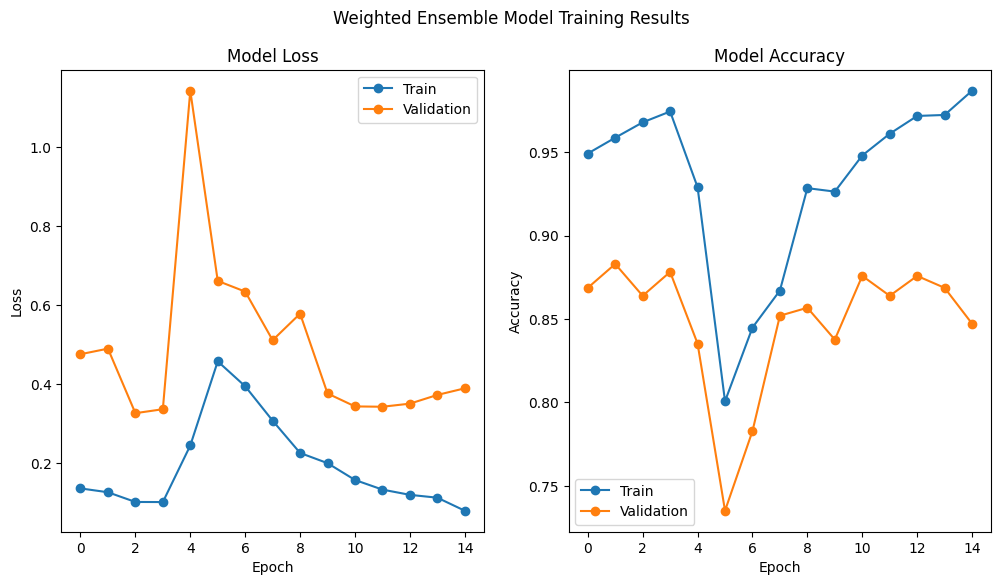

In [62]:
plot_training(weighted_ensemble_history, "Weighted Ensemble Model Training Results")

In [63]:
weighted_ensemble_model.save(WEIGHTED_ENSEMBLE_MODEL_PATH)

## 4. Testing Model

In [64]:
from keras.models import load_model
import numpy as np
from PIL import Image, ImageOps
import requests
import tensorflow as tf

class_labels = ['Cataract', 'diabetic_retinopathy', 'glaucoma', 'Normal']

# fname = "class.txt"
# with open(fname ,"r") as f:
#     class_labels = sorted(set([word for line in f for word in line.split()]))


def load_and_prep_image(filepath, image_size):
    img = tf.io.read_file(filepath) #read image

    img = tf.io.decode_image(img,channels=3)
    # img = tf.image.decode_image(img) # decode the image to a tensor
    img = tf.image.resize(img, size = [image_size, image_size]) # resize the image
    img = img/255. # rescale the image
    return img

def classify_image(filepath, model_path, image_size=229, class_labels=class_labels):
    # loading trained model
    trained_model=load_model(model_path, compile=False)
    trained_model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    # Import the target image and preprocess it
    img = load_and_prep_image(filepath, image_size)

    prediction = trained_model.predict(tf.expand_dims(img, axis=0))
    index = np.argmax(prediction)

    class_name = class_labels[index]
    confidence_score = prediction[0][index]

    return {
        'class' : class_name,
        'score' : f'{confidence_score*100:02.2f}%'
    }

def predict_class(filepath, model_path, image_size = 299):
    np.set_printoptions(suppress=True)

    model = load_model(model_path ,compile=False)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    data = np.ndarray(shape=(1, image_size, image_size, 3), dtype=np.float32)

    # Replace this with the path to your image
    image = Image.open(filepath).convert("RGB")

    # resizing the image to be at least 299 X 299 and then cropping from the center
    size = (image_size, image_size)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # turn the image into a numpy array
    image_array = np.asarray(image)

    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Load the image into the array
    data[0] = normalized_image_array

    # Predicts the model
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_labels[index]
    confidence_score = prediction[0][index]

    result = {
        "class" : class_name,
        "score" :f'{(confidence_score*100):2.2f}%'
    }

    return result

def prepare_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [image_size, image_size])

    image = np.expand_dims(image, axis=0)

    return image

def classify_using_bytes(image_bytes, model_path, image_size):
    model = load_model(model_path, compile=False)
    model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    prediction = model.predict(prepare_image(image_bytes, image_size))
    index = np.argmax(prediction, axis=1)[0]

    class_name = class_labels[index]
    confidence_score = prediction[0][index]

    return {
        'class' : class_name,
        'score' : f'{confidence_score*100:02.2f}%'
    }

def classify_using_url(url, model_path, image_size=299):
    image_source = requests.get(url).content

    return classify_using_bytes(image_source, model_path, image_size)


In [65]:
image_size = 224

In [66]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/normal/2334_right.jpg"
classify_image(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 1s 1s/step


{'class': 'Normal', 'score': '99.94%'}

In [67]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/diabetic_retinopathy/10081_right.jpeg"
predict_class(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 0s 147ms/step


{'class': 'diabetic_retinopathy', 'score': '100.00%'}

In [68]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/glaucoma/1212_left.jpg"
predict_class(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 0s 152ms/step


{'class': 'glaucoma', 'score': '94.66%'}

In [69]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/cataract/2101_right.jpg"
predict_class(filepath, ENSEMBLE_MODEL_PATH, image_size)

1/1 [==============================] - 4s 4s/step


{'class': 'Cataract', 'score': '96.99%'}

In [70]:
filepath = "/content/drive/MyDrive/ensemble-learning/dataset/test/cataract/2101_right.jpg"
predict_class(filepath, VGG16_MODEL_PATH, image_size)

1/1 [==============================] - 0s 332ms/step


{'class': 'Cataract', 'score': '98.75%'}